In [1]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bananapple","key":"4d21f4c0d250944c9623a28c5088a1b5"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tritrungx6/15catbreeds

 99% 433M/436M [00:15<00:00, 30.1MB/s]
100% 436M/436M [00:15<00:00, 28.6MB/s]


In [6]:
#압축풀기
import zipfile

local_zip = '/content/15catbreeds.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/cat-breed')
zip_ref.close()

In [7]:
base_dir='/content/cat-breed/Cat-Breeds'

In [8]:
base_list=os.listdir(base_dir)
print(len(base_list))

15


In [9]:
sum=0
for i in base_list:
  train_img=os.path.join(base_dir,'{}'.format(i))
  train_img_list=os.listdir(train_img)
  sum+=len(train_img_list)
print(sum)

2929


# imagedatagenerator 설정

In [10]:
batch=32
img_width=250
img_height=250

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 shear_range=0.3,
                                 zoom_range=0.3,
                                 horizontal_flip=True,
                                 fill_mode='nearest',
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 validation_split=0.1
                                 )
train_generator=train_datagen.flow_from_directory(base_dir,
                                                  batch_size=batch,
                                                  class_mode='sparse',
                                                  target_size=(img_width,img_height),
                                                  subset='training'
                                                  )
val_generator=train_datagen.flow_from_directory(base_dir,
                                                batch_size=batch,
                                                class_mode='sparse',
                                                target_size=(img_width,img_height),
                                                subset='validation'
                                                )

Found 2637 images belonging to 15 classes.
Found 292 images belonging to 15 classes.


In [12]:
#라벨
print(train_generator.class_indices.items())

dict_items([('Abyssinian', 0), ('Bengal', 1), ('Birman', 2), ('Bombay', 3), ('British_Shorthair', 4), ('Dilute_Calico', 5), ('Egyptian_Mau', 6), ('Havana', 7), ('Maine_Coon', 8), ('Persian', 9), ('Ragdoll', 10), ('Russian_Blue', 11), ('Siamese', 12), ('Sphynx', 13), ('Tuxedo', 14)])


# 모델만들기

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers


In [ ]:
#pre-trainded model 불러오기
base_model=Xception(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
#특징 추출기
base_model.trainabel=False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
base_model=Xception(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))
base_model.trainabel=False

model=Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(15, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_11 (Dropout)        (None, 131072)            0         
                                                                 
 dense_19 (Dense)            (None, 64)                8388672   
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 15)                975       
                                                                 
Total params: 29,251,127
Trainable params: 29,196,599


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics='accuracy'
              )

# 학습하기

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping=EarlyStopping(monitor='val_loss',
                            patience=5
                            )
history=model.fit(train_generator,
                  validation_data=val_generator,
                  epochs=25,
                  callbacks=[earlystopping]
                  )

Epoch 1/25
83/83 [==============================] - 76s 906ms/step - loss: 1.1281 - accuracy: 0.6367 - val_loss: 0.4885 - val_accuracy: 0.8253
Epoch 2/25
83/83 [==============================] - 72s 857ms/step - loss: 0.6065 - accuracy: 0.8157 - val_loss: 0.3937 - val_accuracy: 0.8801
Epoch 3/25
83/83 [==============================] - 73s 875ms/step - loss: 0.4140 - accuracy: 0.8783 - val_loss: 0.3183 - val_accuracy: 0.8870
Epoch 4/25
83/83 [==============================] - 74s 885ms/step - loss: 0.3001 - accuracy: 0.9090 - val_loss: 0.2499 - val_accuracy: 0.9178
Epoch 5/25
83/83 [==============================] - 74s 883ms/step - loss: 0.2273 - accuracy: 0.9363 - val_loss: 0.4026 - val_accuracy: 0.8801
Epoch 6/25
83/83 [==============================] - 75s 902ms/step - loss: 0.2084 - accuracy: 0.9424 - val_loss: 0.3761 - val_accuracy: 0.9041
Epoch 7/25
83/83 [==============================] - 75s 893ms/step - loss: 0.1843 - accuracy: 0.9488 - val_loss: 0.3339 - val_accuracy: 0.9075

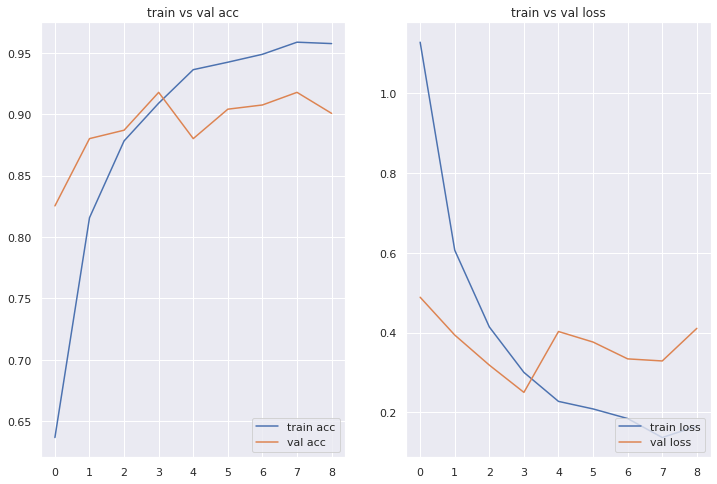

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epoch_range=range(9)

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.plot(epoch_range,acc, label='train acc')
plt.plot(epoch_range,  val_acc, label='val acc')
plt.legend(loc='lower right')
plt.title('train vs val acc')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label='train loss')
plt.plot(epoch_range, val_loss, label='val loss')
plt.legend(loc='lower right')
plt.title('train vs val loss')

plt.show()

In [ ]:
#모델 저장하기
from keras.models import load_model
model.save('고양이 종 분류.h5')

In [14]:
#고양이 종 분류
from keras.models import load_model
catbreed=load_model('/content/drive/MyDrive/데이터저장/모델저장/고양이 종 분류.h5')

In [16]:
#test데이터 정확도 확인
test_loss, test_acc = catbreed.evaluate(train_generator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력
s
print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

83/83 - 48s - loss: 0.0628 - accuracy: 0.0717 - 48s/epoch - 574ms/step

테스트 정확도: 0.07167235761880875

테스트 손실값" 0.06281813234090805
